
# MNIST 手写数据集

数据集地址： https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true

解压后： 

```
mnist_png
├── testing
│   ├── 0
│   ├── 1..8
│   └── 9
└── training
    ├── 0
│   ├── 1..8
    └── 9
```

分为 training 和 testing， 各10个目录，分别表示数字 0 ~ 9

训练集图片 60k，平均每个数字 5000+ 
测试集图片 10k，平均每个数字 1000张 

In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [1]:
# 了解数据集

from pathlib import Path

mnist_path = Path('datasets/mnist_png/')

_dataset = ['training', 'testing']
_labels = list(range(0, 10))

for x in _dataset:
    acc = 0
    for l in _labels:
        p = mnist_path / x / str(l)
        images = list(p.glob('*.png'))
        print(p, len(images))
        acc += len(images)
    print(acc)
# for _p1 in mnist_path.iterdir():
#     for _p2 in _p1.iterdir():
#         print(_p2, len(list(_p2.glob('*.png'))))
#print(len(list(data_path.rglob('*.png'))))

datasets/mnist_png/training/0 5923
datasets/mnist_png/training/1 6742
datasets/mnist_png/training/2 5958
datasets/mnist_png/training/3 6131
datasets/mnist_png/training/4 5842
datasets/mnist_png/training/5 5421
datasets/mnist_png/training/6 5918
datasets/mnist_png/training/7 6265
datasets/mnist_png/training/8 5851
datasets/mnist_png/training/9 5949
60000
datasets/mnist_png/testing/0 980
datasets/mnist_png/testing/1 1135
datasets/mnist_png/testing/2 1032
datasets/mnist_png/testing/3 1010
datasets/mnist_png/testing/4 982
datasets/mnist_png/testing/5 892
datasets/mnist_png/testing/6 958
datasets/mnist_png/testing/7 1028
datasets/mnist_png/testing/8 974
datasets/mnist_png/testing/9 1009
10000


In [5]:
# 用 pytorch 加载数据集

from torchvision import transforms
from datasets import MNIST

trainset = MNIST(root='datasets/mnist_png/training', preload=True, transform=transforms.ToTensor(),)
testset = MNIST(root='datasets/mnist_png/testing', preload=True, transform=transforms.ToTensor(),)

print(len(trainset))
print(len(testset))

60000
10000


In [6]:
from torch.utils.data import DataLoader

trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)
testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

tensor(0) tensor(1) tensor(3) tensor(9) tensor(5) tensor(3) tensor(8) tensor(2) tensor(3) tensor(5) tensor(8) tensor(1) tensor(4) tensor(5) tensor(9) tensor(7)


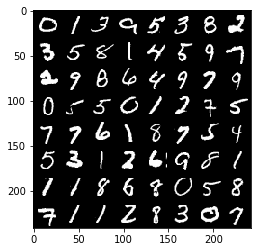

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from torchvision.utils import make_grid

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

# show images
imshow(make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(16)))

torch.Size([1, 28, 28])
torch.Size([3, 28, 28])
torch.Size([1, 3, 28, 28])
torch.Size([3, 28, 28])


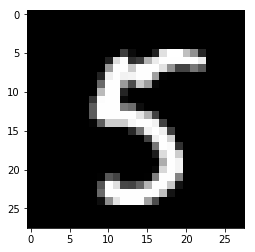

In [8]:
import torch
_tensor = trainset[0][0]
print(_tensor.size())
_tensor = torch.cat((_tensor, _tensor, _tensor), 0)
print(_tensor.size())
_tensor = _tensor.view(1, _tensor.size(0), _tensor.size(1), _tensor.size(2))
print(_tensor.size())
_tensor = _tensor.squeeze()
print(_tensor.size())

plt.imshow(_tensor.numpy().transpose((1, 2, 0)))

In [11]:
import torch.optim as optim
import torch.nn as nn
from models.simple import MNIST_SimpleCNN

device = torch.device('cuda:0')
model = MNIST_SimpleCNN().to(device)


In [13]:

from time import time

import torch.nn.functional as F


def evaluate(model, dataset):
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    data_size = len(dataset.dataset)
    with torch.no_grad():
        for data, target in dataset:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= data_size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, data_size, 100. * correct / data_size))

def train(model, optimizer, trainset, testset, epoch=1, log_interval=100):
#     model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        model.train()  # set training mode
        start = time()
        for batch_idx, (data, target) in enumerate(trainset):
            # bring data to the computing device, e.g. GPU
            data, target = data.to(device), target.to(device)

            # forward pass
            output = model(data)
            # compute loss: negative log-likelihood
            loss = F.cross_entropy(output, target)
            
            # backward pass
            # clear the gradients of all tensors being optimized.
            optimizer.zero_grad()
            # accumulate (i.e. add) the gradients from this forward pass
            loss.backward()
            # performs a single optimization step (parameter update)
            optimizer.step()
            
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset.dataset),
                    100. * batch_idx / len(trainset), loss.item()))
            iteration += 1
            
        end = time()
        print('{:.2f}s'.format(end-start))
        evaluate(model, testset) # evaluate at the end of epoch


In [16]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainset_loader, testset_loader, epoch=5)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299054
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.981630
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.689998
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.527984
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.314284
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.476959
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.409119
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.305704
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.818035
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.333582
5.19s


/home/yangdong/.conda/envs/cs231n/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1270, Accuracy: 9612/10000 (96%)

Train Epoch: 1 [3968/60000 (7%)]	Loss: 0.414452
Train Epoch: 1 [10368/60000 (17%)]	Loss: 0.360926
Train Epoch: 1 [16768/60000 (28%)]	Loss: 0.209572
Train Epoch: 1 [23168/60000 (39%)]	Loss: 0.171989
Train Epoch: 1 [29568/60000 (49%)]	Loss: 0.319266
Train Epoch: 1 [35968/60000 (60%)]	Loss: 0.336662
Train Epoch: 1 [42368/60000 (71%)]	Loss: 0.340083
Train Epoch: 1 [48768/60000 (81%)]	Loss: 0.317899
Train Epoch: 1 [55168/60000 (92%)]	Loss: 0.253588
4.95s

Test set: Average loss: 0.0904, Accuracy: 9720/10000 (97%)

Train Epoch: 2 [1536/60000 (3%)]	Loss: 0.305535
Train Epoch: 2 [7936/60000 (13%)]	Loss: 0.102832
Train Epoch: 2 [14336/60000 (24%)]	Loss: 0.277273
Train Epoch: 2 [20736/60000 (35%)]	Loss: 0.175464
Train Epoch: 2 [27136/60000 (45%)]	Loss: 0.205808
Train Epoch: 2 [33536/60000 (56%)]	Loss: 0.283663
Train Epoch: 2 [39936/60000 (67%)]	Loss: 0.221322
Train Epoch: 2 [46336/60000 (77%)]	Loss: 0.197611
Train Epoch: 2 [52736/60000